In [1]:
import sys
!{sys.executable} -m pip install deap


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from deap import base, creator, tools, algorithms
import random

# Load dataset from CSV
data = pd.read_csv('./eclipse.csv')

# Convert 'post' column to binary
data['post_binary'] = data['post'].apply(lambda x: 1 if x > 0 else 0)

# Prepare the feature matrix (X) and the target vector (y)
X = data.drop(columns=['plugin', 'filename', 'pre', 'post', 'post_binary'])  # Dropping non-numeric and target columns
y = data['post_binary']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [3]:
# Define the evaluation function for the Genetic Algorithm
def evalFeatureSelection(individual):
    selected_features = [i for i, val in enumerate(individual) if val == 1]
    if len(selected_features) == 0:
        return (0,)
    
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    
    clf = KNeighborsClassifier()
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    return (accuracy,)

In [4]:
# Set up the Genetic Algorithm using DEAP

# Create the types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Register the functions
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalFeatureSelection)



In [5]:
# Run the Genetic Algorithm for feature selection:
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	min     	max     
0  	50    	0.83455	0.824418	0.844871
1  	30    	0.837199	0.831026	0.844556
2  	30    	0.83983 	0.829138	0.844556
3  	29    	0.840894	0.833543	0.844871
4  	33    	0.842517	0.836375	0.848018
5  	33    	0.843021	0.835116	0.848018
6  	32    	0.845148	0.839522	0.849276
7  	26    	0.84623 	0.842039	0.849276
8  	26    	0.846639	0.837948	0.849276
9  	31    	0.847004	0.834802	0.85022 
10 	28    	0.847791	0.834487	0.85085 
11 	33    	0.848527	0.839207	0.852423
12 	25    	0.849125	0.835116	0.852423
13 	36    	0.849868	0.83606 	0.852738
14 	34    	0.849528	0.839522	0.853052
15 	24    	0.85061 	0.841724	0.853682
16 	28    	0.851259	0.841095	0.853682
17 	28    	0.85197 	0.837948	0.853682
18 	26    	0.851542	0.839522	0.853682
19 	24    	0.852284	0.842354	0.853682
20 	33    	0.85124 	0.835431	0.853682


In [6]:
# Train and evaluate the Naive Bayes classifier using the best feature subset found:
best_individual = hof[0]
selected_features = [i for i, val in enumerate(best_individual) if val == 1]
print("Best individual: ", best_individual)
print("Number of selected features: ", len(selected_features))

Best individual:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
Number of selected features:  90


In [7]:
# Train the classifier
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = KNeighborsClassifier()
clf.fit(X_train_selected, y_train)

# Test the classifier
y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.8536815607300189
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2690
           1       0.55      0.25      0.35       488

    accuracy                           0.85      3178
   macro avg       0.71      0.61      0.63      3178
weighted avg       0.83      0.85      0.83      3178



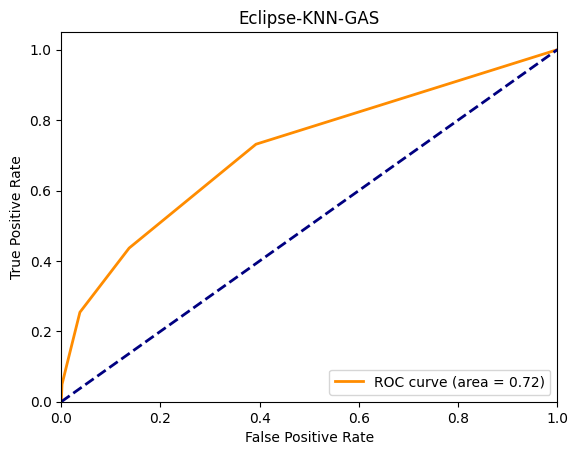

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Save AUC values
df = pd.DataFrame({
    'AUC': roc_auc,
    'FPR': fpr,
    'TPR': tpr
})
df.to_csv('./AUC_Extracts/Eclipse/Eclipse_KNN_GAS.csv', index=False)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Eclipse-KNN-GAS')
plt.legend(loc="lower right")
plt.show()